In [4]:
!pip3 install joblib

    100% |################################| 184kB 3.1MB/s ta 0:00:01
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
# import importlib
# import local_utils; importlib.reload(local_utils)
from local_utils import *

# separate by length
# http://www.jakob-aungiers.com/articles/a/LSTM-Neural-Network-for-Time-Series-Prediction NORMALIZATION


# TCN
# Dilation Convs
# Auxiliary loss?

# different normalization (standard, minmax, maxlog)
# mse vs mae
# fit on whole

# clean holidays
# better outliears handling
# since features

# different architecture
# LeakyReLU
# Batch Temporal Normalization
# Stateful
# Dropin
# Attention

/opt/conda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Seed: 7961730


### Loading data

In [6]:
merged_df = pd.read_hdf("../data/forecast/prepared_data.hdf", key="key_0", mode="r")
print(len(merged_df))
merged_df.head()

7869006


,site_id,timestamp,forecast_id,value,part,time_diff,date,time,week_day,year,...,avg_temperature,avg_day_distance,avg_day_temperature,avg_month_distance,avg_month_temperature,has_weather,closest_temperature_base_diff,avg_temperature_base_diff,avg_day_temperature_base_diff,avg_month_temperature_base_diff
1138708,1,2014-09-03,1,909655.510515,train,1 days,2014-09-03,00:00:00,2,2014,...,19.600000,22.872779,21.184746,22.418264,18.695938,True,1.000000,1.600000,3.184746,0.695938
1141835,1,2014-09-04,1,1748273.124752,train,1 days,2014-09-04,00:00:00,3,2014,...,21.300000,22.840771,23.375000,22.418264,18.695938,True,2.000000,3.300000,5.375000,0.695938
1144962,1,2014-09-05,1,nan,train,1 days,2014-09-05,00:00:00,4,2014,...,23.350000,22.827057,26.521667,22.418264,18.695938,True,4.000000,5.350000,8.521667,0.695938
1148089,1,2014-09-06,1,nan,train,1 days,2014-09-06,00:00:00,5,2014,...,21.600000,22.872779,19.944068,22.418264,18.695938,True,3.000000,3.600000,1.944068,0.695938
1151216,1,2014-09-07,1,nan,train,1 days,2014-09-07,00:00:00,6,2014,...,15.800000,22.840771,17.680000,22.418264,18.695938,True,5.000000,2.200000,0.320000,0.695938


In [3]:
# merged_df.isnull().sum()

### Handling NaNs

In [7]:
map_sizes = {
    420: 420,
    418: 420,
    150: 150,
    148: 150,
    149: 150,
    1156: 1156,
    1155: 1156,
}

merged_df = merged_df.merge(merged_df.groupby("forecast_id").size().transform(lambda size: map_sizes[size]).to_frame("size").reset_index(), 
                            how="left", on="forecast_id") 

In [8]:
print(merged_df["value"].isnull().sum())
merged_df.dropna(subset=["value"], inplace=True)
print(merged_df["value"].isnull().sum())

86601
0


In [9]:
train_cond = merged_df["part"]=="train"
test_cond = merged_df["part"]=="test"

In [10]:
merged_df["normalized_value"] = merged_df["value"]

merged_df.loc[train_cond, "normalized_value"] = merged_df[train_cond]\
                                                        .groupby("forecast_id")["normalized_value"]\
                                                        .transform(lambda group: fit_transform(group, minmax=False))

In [11]:
norm_mean = merged_df[train_cond]["normalized_value"].mean()
norm_std = merged_df[train_cond]["normalized_value"].std()
merged_df[train_cond][["normalized_value"]].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])

,normalized_value
count,6473229.000000
mean,-0.006375
std,0.995711
min,-18.623330
1%,-1.756175
5%,-1.250574
25%,-0.811081
50%,-0.200699
75%,0.802794
95%,1.636672


In [12]:
merged_df.loc[train_cond&(np.abs(merged_df["normalized_value"]-norm_mean)>=3*norm_std), "value"] = np.nan
print(merged_df["value"].isnull().sum())
merged_df.dropna(subset=["value"], inplace=True)
print(merged_df["value"].isnull().sum())
merged_df.drop(columns="normalized_value", inplace=True)

28501
0


### Prepare features

In [13]:
merged_df[merged_df["site_id"]==93][["site_id", "forecast_id", "timestamp", "value"]].head()

,site_id,forecast_id,timestamp,value
2208776,93,1955,2014-05-22 16:30:00,110.325792
2208778,93,1955,2014-05-22 18:30:00,90.735231
2208779,93,1955,2014-05-22 19:30:00,120.636614
2208780,93,1955,2014-05-22 20:30:00,113.419038
2208781,93,1955,2014-05-22 21:30:00,80.424409


In [14]:
merged_df["cat_site_id"] = merged_df["site_id"]

id_cols = ["forecast_id", "site_id", "part", "timestamp"]
value_cols = ["value"]
num_cols = ["surface", "base_temperature", "size", # TODO
            "closest_distance", "closest_temperature", "closest_temperature_base_diff",
            "avg_distance", "avg_temperature", "avg_temperature_base_diff",
            "avg_day_distance", "avg_day_temperature", "avg_day_temperature_base_diff",
            "avg_month_distance", "avg_month_temperature", "avg_month_temperature_base_diff"]
bin_cols = ["is_holiday", "is_day_off", "has_weather"]
cat_cols = ["cat_site_id", "time_diff", "month", "week", "day", "hour", "time", "week_day", "sampling", "holiday"]
cat_sizes_map = {col_name: merged_df[col_name].unique().shape[0] for col_name in cat_cols}

In [15]:
merged_df = merged_df.loc[:,id_cols + value_cols + num_cols + bin_cols + cat_cols]\
    .pipe(fit_transform_cols, cols=num_cols, new_cols=num_cols, groupby=None, minmax=True, feature_range=(-1,1))\
    .pipe(binarize_cols, cols=bin_cols, new_cols=bin_cols)\
    .pipe(factorize_cols, cols=cat_cols, new_cols=cat_cols)

/opt/conda/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [19]:
merged_df.shape

(7753904, 33)

In [22]:
merged_df = merged_df.reset_index()

In [23]:
merged_df.to_feather('../data/forecast/savva_features')


In [13]:
train_df = merged_df[merged_df["part"] == "train"].copy().reset_index(drop=True)
test_df = merged_df[merged_df["part"] == "test"].copy().reset_index(drop=True) 

In [14]:
forecast_scalers = {}
site_scalers = {}

# train_df = train_df\
#     .pipe(fit_maxlog_scalers, col="value", forecast_scalers=forecast_scalers, site_scalers=site_scalers)\
#     .pipe(transform_maxlog, col="value", new_col="scaled_value", forecast_scalers=forecast_scalers, site_scalers=site_scalers)
    
train_df = train_df\
    .pipe(fit_scalers, col="value", forecast_scalers=forecast_scalers, site_scalers=site_scalers, minmax=False, feature_range=(-1,1))\
    .pipe(transform, col="value", new_col="scaled_value", forecast_scalers=forecast_scalers, site_scalers=site_scalers)
    
train_df["scaled_value"].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])

count   6444728.000000
mean         -0.005818
std           0.995479
min         -13.632182
1%           -1.763475
5%           -1.266635
25%          -0.824906
50%          -0.217861
75%           0.830617
95%           1.654385
99%           2.332414
max          19.083962
Name: scaled_value, dtype: float64

In [15]:
# TODO
scaled_mean = train_df["scaled_value"].mean()
scaled_std = train_df["scaled_value"].std()
train_df.loc[(np.abs(train_df["scaled_value"]-scaled_mean)>=3*scaled_std), "scaled_value"] = np.nan
print(train_df["scaled_value"].isnull().sum())
train_df.dropna(subset=["scaled_value"], inplace=True)
print(train_df["scaled_value"].isnull().sum())

16245
0


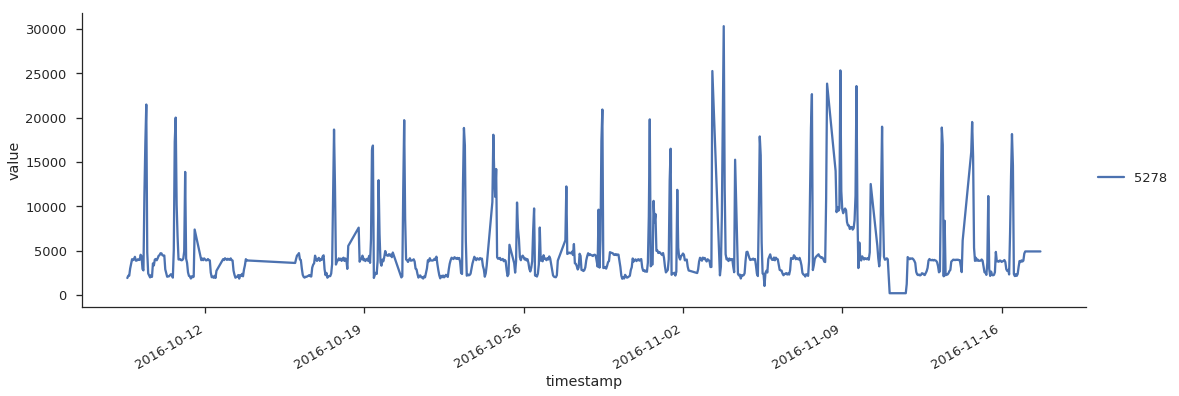

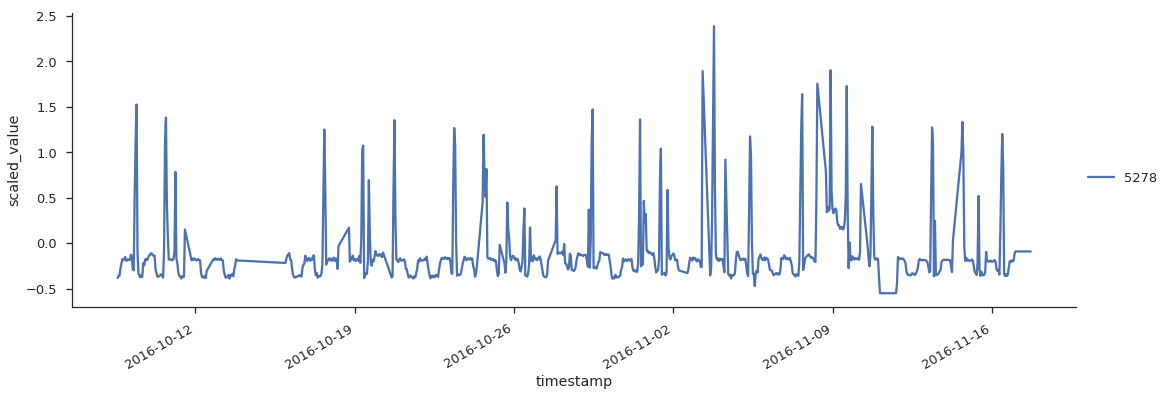

In [16]:
cond_id = 5278
cond_col = "forecast_id"
# cond_col = "site_id"

plot_graph(train_df, cond_id, cond_col, "value")
plot_graph(train_df, cond_id, cond_col, "scaled_value")

### Preparing windows

In [17]:
window_size = 50
num_valid_windows = 10

def convert_to_seqs(seq, window_size):
    inx = np.arange(0, len(seq) - window_size + 1)
    return np.stack([seq[start:start+window_size] for start in inx])

In [18]:
# TODO CHECK IT
train_df = train_df.groupby("forecast_id").filter(lambda group: len(group) >= window_size + num_valid_windows)

train_df.sort_values(["forecast_id", "timestamp"], inplace=True)
train_df.reset_index(drop=True, inplace=True)

train_groups = train_df.groupby("forecast_id")
samples_inx = Parallel(n_jobs=cpu_cores)(delayed(convert_to_seqs)(group[1].index, window_size) for group in train_groups)

train_samples_inx = []
valid_samples_inx = []
for sample in samples_inx:
    train_samples_inx.append(sample[:-num_valid_windows])
    valid_samples_inx.append(sample[-num_valid_windows:])

In [19]:
# Appending last window of training data
train_last_window_df = train_groups.tail((window_size-1))
test_df = test_df.append(train_last_window_df, ignore_index=True)

test_df.sort_values(["forecast_id", "timestamp"], inplace=True)
test_df.reset_index(drop=True, inplace=True) 

test_groups = test_df.groupby("forecast_id")
test_samples_inx = Parallel(n_jobs=cpu_cores)(delayed(convert_to_seqs)(group[1].index, window_size) for group in test_groups)

In [20]:
X = train_df[num_cols+bin_cols+cat_cols].values
y = train_df["scaled_value"].values
X_test = test_df[num_cols+bin_cols+cat_cols].values

### Train model

In [21]:
def get_cat_emb(cat_name, cat_size, window_size, max_emb_size=50):
    emb_size = min([(cat_size+2)//3, max_emb_size]) # (cat_size+1)//2
    
    emb_inp = Input((window_size,1), dtype='int64', name=cat_name+'_in')
    emb = Embedding(cat_size, emb_size, trainable=True, name=cat_name+'_emb')(emb_inp)
    emb = Lambda(lambda emb: K.squeeze(emb, axis=-2), name=cat_name+'_squeeze_emb')(emb)
    return emb_inp, emb

def Seq2SeqWindow1(window_size, num_cols, bin_cols, cat_cols, cat_sizes_map, activation="linear"):
    num_inps = []
    for num_col in num_cols:
        num_inp = Input((window_size,1), name=num_col+'_in')
        num_inps.append(num_inp)
        
    bin_inps = []
    for bin_col in bin_cols:
        bin_inp = Input((window_size,1), name=bin_col+'_in')
        bin_inps.append(bin_inp)
    
    emb_inps = []
    embs = []
    for cat_col in cat_cols:
        emb_inp, emb = get_cat_emb(cat_col, cat_sizes_map[cat_col], window_size)
        emb_inps.append(emb_inp)
        embs.append(emb)
    
    x = concatenate(num_inps+bin_inps+embs, name='concat')
    x = Dropout(0.05)(x)
    
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
#     x = Dropout(0.15)(x)

#     x_output = Dense(window_size, activation=activation)(x)
    x_output = LSTM(window_size, activation=activation)(x)
    return Model(inputs=num_inps + bin_inps + emb_inps, outputs=x_output)

def Seq2SeqWindow(window_size, num_cols, bin_cols, cat_cols, cat_sizes_map, activation="linear"):
    num_inps = []
    for num_col in num_cols:
        num_inp = Input((window_size,1), name=num_col+'_in')
        num_inps.append(num_inp)
        
    bin_inps = []
    for bin_col in bin_cols:
        bin_inp = Input((window_size,1), name=bin_col+'_in')
        bin_inps.append(bin_inp)
    
    emb_inps = []
    embs = []
    for cat_col in cat_cols:
        emb_inp, emb = get_cat_emb(cat_col, cat_sizes_map[cat_col], window_size)
        emb_inps.append(emb_inp)
        embs.append(emb)
    
    entity_emb = concatenate(num_inps+bin_inps+embs, name='entity_emb')
    entity_emb = Dropout(0.15)(entity_emb)
    
    cnn3 = Conv1D(128, kernel_size=3, activation="relu", padding="same")(entity_emb)
    cnn4 = Conv1D(128, kernel_size=4, activation="relu", padding="same")(entity_emb)
    cnn5 = Conv1D(128, kernel_size=5, activation="relu", padding="same")(entity_emb)
    
    x = concatenate([cnn3, cnn4, cnn5])
    
    cnn3 = Conv1D(128, kernel_size=3, activation="relu", padding="same")(x)
    cnn4 = Conv1D(128, kernel_size=4, activation="relu", padding="same")(x)
    cnn5 = Conv1D(128, kernel_size=5, activation="relu", padding="same")(x)
    
    x = concatenate([x, cnn3, cnn4, cnn5])
    x = GlobalMaxPool1D()(x)
    
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)
    
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)
    
    x_output = Dense(window_size, activation=activation)(x)
#     x_output = LSTM(window_size, activation=activation)(x)
    return Model(inputs=num_inps + bin_inps + emb_inps, outputs=x_output)

model_fun = Seq2SeqWindow
model_name = model_fun.__name__
model = model_fun(window_size, num_cols, bin_cols, cat_cols, cat_sizes_map, activation="linear")
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cat_site_id_in (InputLayer)     (None, 50, 1)        0                                            
__________________________________________________________________________________________________
time_diff_in (InputLayer)       (None, 50, 1)        0                                            
__________________________________________________________________________________________________
month_in (InputLayer)           (None, 50, 1)        0                                            
__________________________________________________________________________________________________
week_in (InputLayer)            (None, 50, 1)        0                                            
__________________________________________________________________________________________________
day_in (In

In [22]:
class ForecastFeatureSequence(Sequence):
    
    def __init__(self, X, y, samples_inx, forecasts_batch_size, samples_batch_size):
        self.X, self.y = X, y
        self.samples_inx = samples_inx
        self.forecasts_batch_size = forecasts_batch_size
        self.samples_batch_size = samples_batch_size
        
        self.inx = np.arange(0, len(self.samples_inx))
        np.random.shuffle(self.inx)

    def __len__(self):
        return math.ceil(self.inx.shape[0] / self.forecasts_batch_size)

    def __getitem__(self, i):
        forecast_batch_inx = self.inx[i*self.forecasts_batch_size:(i+1)*self.forecasts_batch_size]
        
        X_batch = []
        y_batch = []
        for inx in forecast_batch_inx:
            samples_batch_inx = np.random.randint(0, len(self.samples_inx[inx]), size=self.samples_batch_size)
            X_batch.append(self.X[self.samples_inx[inx][samples_batch_inx]])
            y_batch.append(self.y[self.samples_inx[inx][samples_batch_inx]])
            
        X_batch = np.concatenate(X_batch)
        y_batch = np.concatenate(y_batch)
        
        return split_inputs(X_batch), y_batch
    
    def on_epoch_end(self):
        np.random.shuffle(self.inx)
        
class PredictForecastFeatureSequence(Sequence):
    
    def __init__(self, X, y, samples_inx, forecasts_batch_size=1024, shuffle=True):
        self.X = X
        self.y = y if type(y) is np.ndarray else np.zeros(shape=(X.shape[0],1))
        
        self.samples_inx = samples_inx
        self.forecasts_batch_size = forecasts_batch_size

        self.inx = np.arange(0, len(self.samples_inx))
        
    def __len__(self):
        return math.ceil(self.inx.shape[0] / self.forecasts_batch_size)

    def __getitem__(self, i):
        forecast_batch_inx = self.inx[i*self.forecasts_batch_size:(i+1)*self.forecasts_batch_size]

        X_batch = []
        y_batch = []
        for inx in forecast_batch_inx:
            X_batch.append(self.X[self.samples_inx[inx]])
            y_batch.append(self.y[self.samples_inx[inx]])
            
        X_batch = np.concatenate(X_batch)
        y_batch = np.concatenate(y_batch)
        
        return split_inputs(X_batch), y_batch

trn_seq = ForecastFeatureSequence(X, y, train_samples_inx, forecasts_batch_size=32, samples_batch_size=64)
trn_pred_seq = PredictForecastFeatureSequence(X, y, train_samples_inx, forecasts_batch_size=8)
val_seq = PredictForecastFeatureSequence(X, y, valid_samples_inx, forecasts_batch_size=32)
test_seq = PredictForecastFeatureSequence(X_test, None, test_samples_inx, forecasts_batch_size=8)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
model_checkpoint = ModelCheckpoint(models_dir+model_name+'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=0, min_lr=0.0001, verbose=1)
# lr_schedule = LearningRateScheduler(lr_change, verbose=1)
# tensorboard = TensorBoard(log_dir='logs', write_graph=False)

In [ ]:
# model.compile(loss="mae", optimizer=optimizers.Adam(0.001), metrics=["mse", keras_rmse])
model.compile(loss="mse", optimizer=optimizers.Adam(0.001), metrics=["mae", keras_rmse])
# model.compile(loss=keras_rmse, optimizer=optimizers.Adam(0.001), metrics=["mse", "mae"])

In [ ]:
epochs=100
model.fit_generator(
    generator=trn_seq, steps_per_epoch=len(trn_seq),
    validation_data=val_seq, validation_steps=len(val_seq),
    initial_epoch=0, epochs=epochs, shuffle=False, verbose=1,
    callbacks=[early_stop, model_checkpoint, lr_reduce],
    use_multiprocessing=False, workers=cpu_cores, max_queue_size=4*cpu_cores)

In [ ]:
stop

### Evaluation

In [24]:
del model
model = load_model(models_dir+model_name+'.h5', compile=True, custom_objects={"keras_rmse":keras_rmse})

In [25]:
trn_pred_seqs = model.predict_generator(generator=trn_pred_seq, steps=len(trn_pred_seq), verbose=1, 
                                        use_multiprocessing=False, workers=cpu_cores, max_queue_size=4*cpu_cores)
val_pred_seqs = model.predict_generator(generator=val_seq, steps=len(val_seq), verbose=1, 
                                        use_multiprocessing=False, workers=cpu_cores, max_queue_size=4*cpu_cores)

218/218 [==============================] - 2s 10ms/step


In [26]:
trn_pred_inx = np.concatenate(train_samples_inx).flatten()
trn_pred_val = trn_pred_seqs.flatten()
trn_pred = np.stack([trn_pred_inx, trn_pred_val], axis=-1)

val_pred_inx = np.concatenate(valid_samples_inx).flatten()
val_pred_val = val_pred_seqs.flatten()
val_pred = np.stack([val_pred_inx, val_pred_val], axis=-1)

trn_pred_df = pd.DataFrame(trn_pred, index=trn_pred_inx, columns=["index", "pred_scaled_value"])
trn_pred_df = train_df.merge(trn_pred_df.groupby("index")["pred_scaled_value"].mean().reset_index(), 
                             left_index=True, right_on="index")

val_pred_df = pd.DataFrame(val_pred, index=val_pred_inx, columns=["index", "pred_scaled_value"])
val_pred_df = train_df.merge(val_pred_df.groupby("index")["pred_scaled_value"].mean().reset_index(), 
                             left_index=True, right_on="index")

In [27]:
# PREDICTIONS
print("Train:")
print_report(trn_pred_df, "scaled_value", "pred_scaled_value")
print("\nValid:")
print_report(val_pred_df, "scaled_value", "pred_scaled_value")

Train:

NWRMSE: 4173439526850.526; 
RMSE: 0.5338334190119796; 
MSE: 0.3334313848394819; 
MAE: 0.4065729545550743; 
R2: -1.879878786030856e+30;

Valid:

NWRMSE: 4073914365044.93; 
RMSE: 0.5491985442849872; 
MSE: 0.4064350683212799; 
MAE: 0.4479207564287001; 
R2: -7.33059178500155e+30;


861


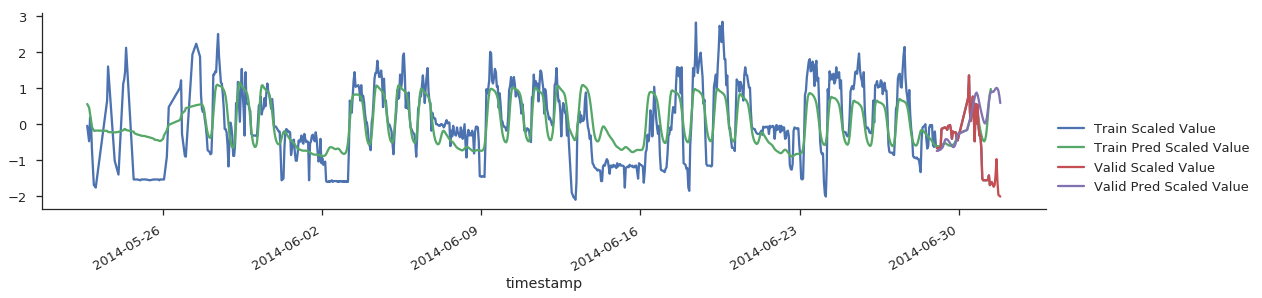

In [28]:
cond_id = 1955 #1955
cond_col = "forecast_id"
# cond_col = "site_id"

print((trn_pred_df[cond_col] == cond_id).sum())
ax=trn_pred_df[(trn_pred_df[cond_col] == cond_id)].plot(x="timestamp", y="scaled_value", figsize=(18, 4), label="Train Scaled Value")
ax=trn_pred_df[(trn_pred_df[cond_col] == cond_id)].plot(ax=ax, x="timestamp", y="pred_scaled_value", figsize=(18, 4), label="Train Pred Scaled Value")
ax=val_pred_df[(val_pred_df[cond_col] == cond_id)].plot(ax=ax, x="timestamp", y="scaled_value", figsize=(18, 4), label="Valid Scaled Value")
val_pred_df[(val_pred_df[cond_col] == cond_id)].plot(ax=ax, x="timestamp", y="pred_scaled_value", figsize=(18, 4), label="Valid Pred Scaled Value")
    
plt.legend(bbox_to_anchor=(1.0, .5))
plt.xlabel("timestamp")
sns.despine()

In [29]:
trn_pred_df = trn_pred_df.pipe(inverse, col="pred_scaled_value", new_col="pred_value", 
                               forecast_scalers=forecast_scalers, site_scalers=site_scalers)
val_pred_df = val_pred_df.pipe(inverse, col="pred_scaled_value", new_col="pred_value", 
                               forecast_scalers=forecast_scalers, site_scalers=site_scalers)

# trn_pred_df = trn_pred_df.pipe(inverse_maxlog, col="pred_scaled_value", new_col="pred_value", 
#                                forecast_scalers=forecast_scalers, site_scalers=site_scalers)
# val_pred_df = val_pred_df.pipe(inverse_maxlog, col="pred_scaled_value", new_col="pred_value", 
#                                forecast_scalers=forecast_scalers, site_scalers=site_scalers)

In [30]:
# PREDICTIONS
print("Train:")
print_report(trn_pred_df, "value", "pred_value")
print("\nValid:")
print_report(val_pred_df, "value", "pred_value")

Train:

NWRMSE: 0.2477774485134608; 
RMSE: 23081.794825810506; 
MSE: 30968446027.438408; 
MAE: 17461.276749698947; 
R2: -2.618250609885271e+24;

Valid:

NWRMSE: 0.40043890114216524; 
RMSE: 24990.300776018707; 
MSE: 44039614018.65488; 
MAE: 19932.65712141601; 
R2: -6.825974348413269e+27;


861


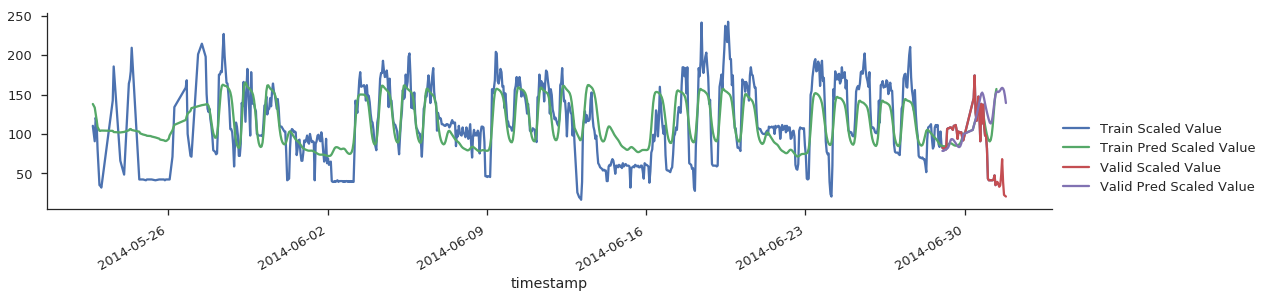

In [31]:
cond_id = 1955 #1955
cond_col = "forecast_id"
# cond_col = "site_id"

print((trn_pred_df[cond_col] == cond_id).sum())
ax=trn_pred_df[(trn_pred_df[cond_col] == cond_id)].plot(x="timestamp", y="value", figsize=(18, 4), label="Train Scaled Value")
ax=trn_pred_df[(trn_pred_df[cond_col] == cond_id)].plot(ax=ax, x="timestamp", y="pred_value", figsize=(18, 4), label="Train Pred Scaled Value")
ax=val_pred_df[(val_pred_df[cond_col] == cond_id)].plot(ax=ax, x="timestamp", y="value", figsize=(18, 4), label="Valid Scaled Value")
val_pred_df[(val_pred_df[cond_col] == cond_id)].plot(ax=ax, x="timestamp", y="pred_value", figsize=(18, 4), label="Valid Pred Scaled Value")
    
plt.legend(bbox_to_anchor=(1.0, .5))
plt.xlabel("timestamp")
sns.despine()

In [32]:
trn_pred_df[trn_pred_df["site_id"]==2][["site_id", "forecast_id", "timestamp", "value", "pred_value",]].head(10)

,site_id,forecast_id,timestamp,value,pred_value
844,2,5,2013-01-01 01:00:00,30159.963708,38311.866867
845,2,5,2013-01-01 02:00:00,29793.536720,38701.981138
846,2,5,2013-01-01 03:00:00,31682.412161,38923.514181
847,2,5,2013-01-01 04:00:00,29881.829185,39864.875087
848,2,5,2013-01-01 05:00:00,30560.328940,39553.513978
849,2,5,2013-01-01 06:00:00,31602.869400,40341.901321
850,2,5,2013-01-01 07:00:00,32359.321061,43231.631748
851,2,5,2013-01-01 08:00:00,36684.061000,45771.096941
852,2,5,2013-01-01 09:00:00,50421.361041,47419.482249
853,2,5,2013-01-01 10:00:00,56556.494230,48651.186553


In [33]:
wrmse_all = metric_by_group(val_pred_df, WRMSE, "value", "pred_value")
print(wrmse_all.idxmin())
print(wrmse_all.idxmax())
wrmse_all.describe(percentiles=[0.1,0.25,0.5,0.75,0.95,0.99])

3472
3237


count   6962.000000
mean       0.400439
std        2.990374
min        0.000000
10%        0.046455
25%        0.095708
50%        0.163441
75%        0.306711
95%        0.977965
99%        2.010094
max      119.071703
dtype: float64

In [34]:
rmse_all = metric_by_group(val_pred_df, rmse, "value", "pred_value")
print(rmse_all.idxmin())
print(rmse_all.idxmax())
rmse_all.describe(percentiles=[0.1,0.25,0.5,0.75,0.95,0.99])

3472
4292


count      6962.000000
mean      24990.300776
std      208377.867806
min           0.000000
10%         220.660349
25%         683.613717
50%        2403.531940
75%        8313.075713
95%       50385.014310
99%      400645.505881
max     9112408.541521
dtype: float64

In [42]:
def power_laws_nwrmse(actual, predicted):
    """ Calcultes NWRMSE for the Power Laws Forecasting competition.
        Data comes in the form:
        col 0: site id
        col 1: timestamp
        col 2: forecast id
        col 3: consumption value
        Computes the weighted, normalized RMSE per site and then
        averages across forecasts for a final score.
    """
    def _per_forecast_wrmse(actual, predicted, weights=None):
        """ Calculates WRMSE for a single forecast period.
        """
        # limit weights to just the ones we need
        weights = weights[:actual.shape[0]]

        # NaNs in the actual should be weighted zero
        nan_mask = np.isnan(actual)
        weights[nan_mask] = 0
        actual[nan_mask] = 0

        # calculated weighted rmse
        total_error = np.sqrt((weights * ((predicted - actual) ** 2)).sum())

        # normalized by actual consumption (avoid division by zero for NaNs)
        denom = np.mean(actual)
        denom = denom if denom != 0.0 else 1e-10
        return total_error / denom

    # flatten and cast forecast ids
    forecast_ids = actual[:, 2].ravel().astype(int)

    # flatten and cast actual + predictions
    actual_float = actual[:, 3].ravel().astype(np.float64)
    predicted_float = predicted[:, 3].ravel().astype(np.float64)

    # get the unique forecasts
    unique_forecasts = np.unique(forecast_ids)
    per_forecast_errors = np.zeros_like(unique_forecasts, dtype=np.float64)

    # pre-calc all of the possible weights so we don't need to do so for each site
    # wi = (3n –2i + 1) / (2n^2)
    n_obs = 200  # longest forecast is ~192 obs
    weights = np.arange(1, n_obs + 1, dtype=np.float64)
    weights = (3 * n_obs - (2 * weights) + 1) / (2 * (n_obs ** 2))

    for i, forecast in enumerate(unique_forecasts):
        mask = (forecast_ids == forecast)
        per_forecast_errors[i] = _per_forecast_wrmse(actual_float[mask],
                                                     predicted_float[mask],
                                                     weights=weights)

    return np.mean(per_forecast_errors)

# trn_nwrmse = power_laws_nwrmse(trn_pred_df[["site_id", "timestamp", "forecast_id", "value"]].values, 
#                                trn_pred_df[["site_id", "timestamp", "forecast_id", "pred_value"]].values)
# print(trn_nwrmse)

val_nwrmse = power_laws_nwrmse(val_pred_df[["site_id", "timestamp", "forecast_id", "value"]].values, 
                               val_pred_df[["site_id", "timestamp", "forecast_id", "pred_value"]].values)
print(val_nwrmse)

0.25291177758859307


349


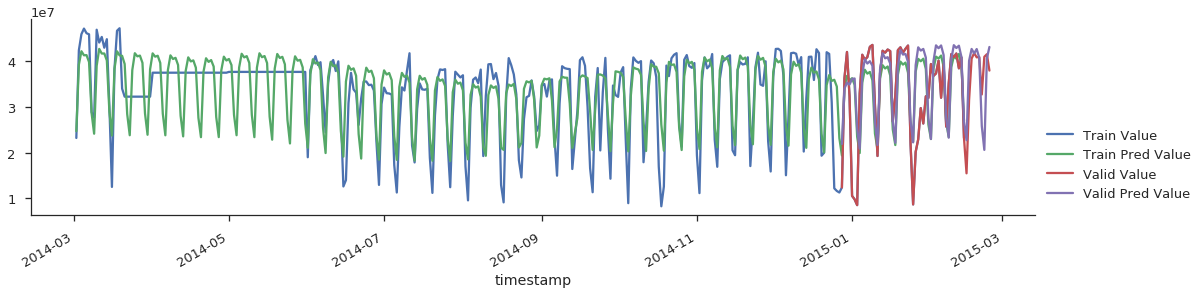

In [43]:
cond_id = 4292 # 8 day off or holiday?
cond_col = "forecast_id"
# cond_col = "site_id"

print((trn_pred_df[cond_col] == cond_id).sum())
ax=trn_pred_df[(trn_pred_df[cond_col] == cond_id)].plot(x="timestamp", y="value", figsize=(18, 4), label="Train Value")
ax=trn_pred_df[(trn_pred_df[cond_col] == cond_id)].plot(ax=ax, x="timestamp", y="pred_value", figsize=(18, 4), label="Train Pred Value")
ax=val_pred_df[(val_pred_df[cond_col] == cond_id)].plot(ax=ax, x="timestamp", y="value", figsize=(18, 4), label="Valid Value")
val_pred_df[(val_pred_df[cond_col] == cond_id)].plot(ax=ax, x="timestamp", y="pred_value", figsize=(18, 4), label="Valid Pred Value")
    
plt.legend(bbox_to_anchor=(1.0, .5))
plt.xlabel("timestamp")
sns.despine()

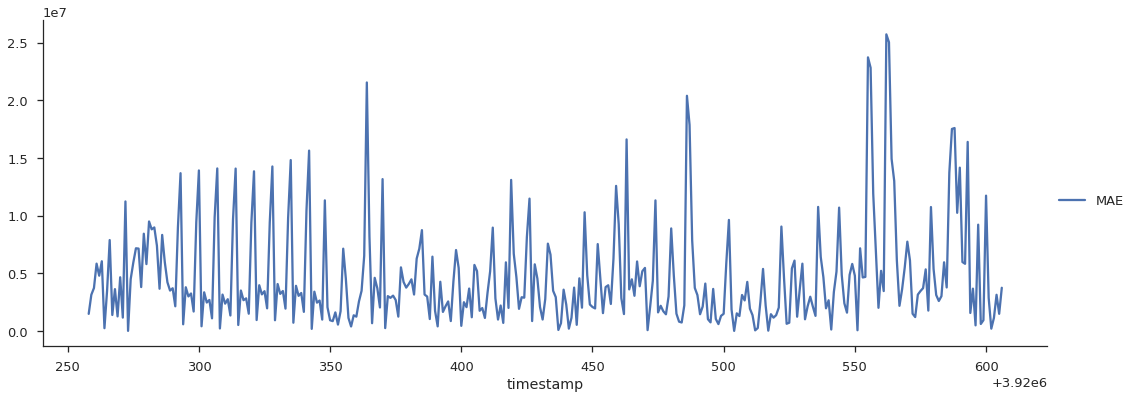

In [44]:
np.abs(trn_pred_df[(trn_pred_df[cond_col] == cond_id)]["value"]-trn_pred_df[(trn_pred_df[cond_col] == cond_id)]["pred_value"])\
.plot(y="mae", figsize=(18, 6), label="MAE")

plt.legend(bbox_to_anchor=(1.0, .5))
plt.xlabel("timestamp")
sns.despine()

### Prediction

In [ ]:
# del model
# model = load_model(models_dir+model_name+'.h5', compile=True, custom_objects={"keras_rmse":keras_rmse})

In [45]:
test_pred_seqs = model.predict_generator(generator=test_seq, steps=len(test_seq), verbose=1, 
                                         use_multiprocessing=False, workers=cpu_cores, max_queue_size=4*cpu_cores)

872/872 [==============================] - 36s 42ms/step


In [46]:
test_pred_inx = np.concatenate(test_samples_inx).flatten()
test_pred_val = test_pred_seqs.flatten()
test_pred = np.stack([test_pred_inx, test_pred_val], axis=-1)

test_pred_df = pd.DataFrame(test_pred, index=test_pred_inx, columns=["index", "pred_scaled_value"])
test_pred_df = test_df.merge(test_pred_df.groupby("index")["pred_scaled_value"].mean().reset_index(), 
                             left_index=True, right_on="index")

test_pred_df = test_pred_df.pipe(inverse, col="pred_scaled_value", new_col="pred_value", forecast_scalers=forecast_scalers, site_scalers=site_scalers)

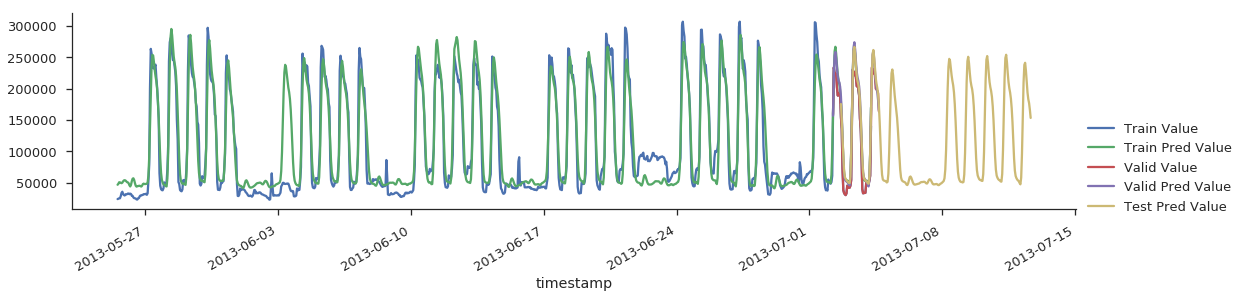

In [49]:
cond_id = 8 # 8 day off or holiday?
cond_col = "forecast_id"
# cond_col = "site_id"

ax=trn_pred_df[(trn_pred_df[cond_col] == cond_id)].plot(x="timestamp", y="value", figsize=(18, 4), label="Train Value")
ax=trn_pred_df[(trn_pred_df[cond_col] == cond_id)].plot(ax=ax, x="timestamp", y="pred_value", figsize=(18, 4), label="Train Pred Value")
ax=val_pred_df[(val_pred_df[cond_col] == cond_id)].plot(ax=ax, x="timestamp", y="value", figsize=(18, 4), label="Valid Value")
ax=val_pred_df[(val_pred_df[cond_col] == cond_id)].plot(ax=ax, x="timestamp", y="pred_value", figsize=(18, 4), label="Valid Pred Value")
test_pred_df[(test_pred_df[cond_col] == cond_id)].plot(ax=ax, x="timestamp", y="pred_value", figsize=(18, 4), label="Test Pred Value")
    
plt.legend(bbox_to_anchor=(1.0, .5))
plt.xlabel("timestamp")
sns.despine()

In [ ]:
stop

In [48]:
submission_df = pd.read_csv(data_dir + 'submission_format.csv', encoding='utf-8', low_memory=False, header=0,
                            names=['obs_id', 'site_id', 'timestamp', 'forecast_id', 'value'])
submission_df["timestamp"] = pd.to_datetime(submission_df["timestamp"])
submission_df = submission_df.merge(test_pred_df[["forecast_id", "site_id", "timestamp", "pred_value"]], 
                                                  how="left", on=["forecast_id", "site_id", "timestamp"])
submission_df.drop(columns="value", inplace=True)
submission_df.rename(columns={"obs_id": "obs_id", "site_id": "SiteId", 
                              "timestamp": "Timestamp", "forecast_id": 
                              "ForecastId", "pred_value": "Value"}, inplace=True)
submission_df.head()

,obs_id,SiteId,Timestamp,ForecastId,Value
0,1677832,1,2015-08-29,1,4366350.597896
1,5379616,1,2015-08-30,1,4429874.953188
2,496261,1,2015-08-31,1,5139134.703725
3,4567147,1,2015-09-01,1,5278517.296477
4,3684873,1,2015-09-02,1,5243004.767681


In [50]:
submission_name = 'Seq2SeqWindow__std__window50__cnn__linear__mse_loss__nwrmse_0.2529.csv'
submission_df.to_csv(results_dir+submission_name, index=False)
FileLink(results_dir+submission_name)

/src/DL/skolbachev/power_laws/forecasting/results/Seq2SeqWindow__std__window50__cnn__linear__mse_loss__nwrmse_0.2529.csv

### End